# Time Series Analysis in Python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_pacf

amzn = pd.read_csv('datasets/AMZN.csv', index_col=0)
ho = pd.read_csv('datasets/CME_HO1.csv', index_col=0)
ng = pd.read_csv('datasets/CME_NG1.csv', index_col=0)
diet = pd.read_csv('datasets/DIET.csv', index_col=0)
dji = pd.read_csv('datasets/DJI.csv', index_col=0)
hrb = pd.read_csv('datasets/HRB.csv', index_col=0)
msft = pd.read_csv('datasets/MSFT.csv', index_col=0)
noaa_tavg = pd.read_csv('datasets/NOAA_TAVG.csv', index_col=0)
sprint_intraday = pd.read_csv('datasets/Sprint_Intraday.txt')
temp_NY = pd.read_csv('datasets/temp_NY.csv', index_col=0)
ufo = pd.read_csv('datasets/UFO.csv', index_col=0)

## Part 1 - Correlation and Autocorrelation

### A "Thin" Application of Time Series

[Google Trends](https://trends.google.com/trends/) allows users to see how often a term is searched for. We downloaded a file from Google Trends containing the frequency over time for the search word "diet", which is pre-loaded in a DataFrame called `diet`. A first step when analyzing a time series is to visualize the data with a plot. You should be able to clearly see a gradual decrease in searches for "diet" throughout the calendar year, hitting a low around the December holidays, followed by a spike in searches around the new year as people make New Year's resolutions to lose weight.

Like many time series datasets you will be working with, the index of dates are strings and should be converted to a datetime index before plotting.

This course touches on a lot of concepts you may have forgotten, so if you ever need a quick refresher, download the [pandas basics Cheat Sheet](https://datacamp-community-prod.s3.amazonaws.com/fbc502d0-46b2-4e1b-b6b0-5402ff273251) and keep it handy!

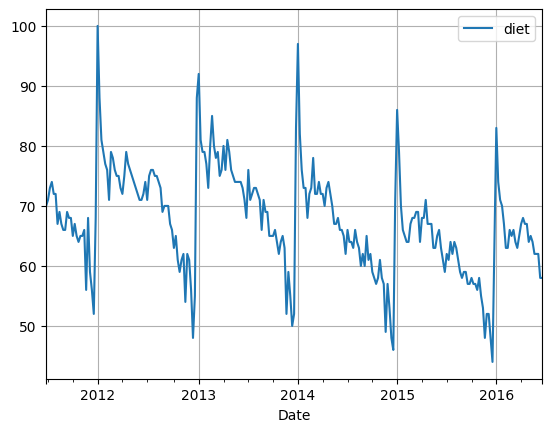

In [2]:
# Convert the date index to datetime
diet.index = pd.to_datetime(diet.index)

# Plot the entire time series diet and show gridlines
diet.plot(grid=True)
plt.show()

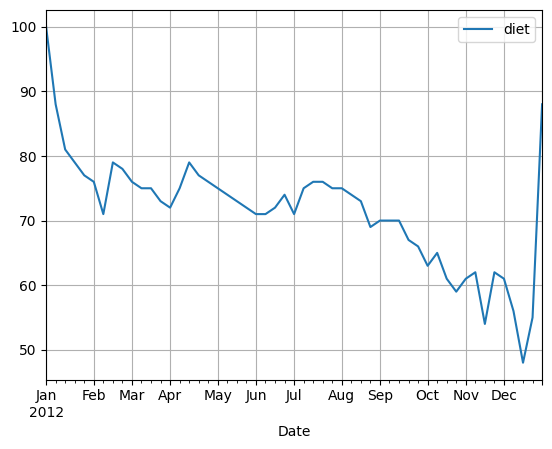

In [3]:
# Slice the dataset to keep only 2012
diet2012 = diet['2012-01-01':'2012-12-31']

# Plot 2012 data
diet2012.plot(grid=True)
plt.show()

### Merging Time Series With Different Dates

Stock and bond markets in the U.S. are closed on different days. For example, although the bond market is closed on Columbus Day (around Oct 12) and Veterans Day (around Nov 11), the stock market is open on those days. One way to see the dates that the stock market is open and the bond market is closed is to convert both indexes of dates into sets and take the difference in sets.

The pandas `.join()` method is a convenient tool to merge the stock and bond DataFrames on dates when both markets are open.

Stock prices and 10-year US Government bond yields, which were downloaded from [FRED](https://fred.stlouisfed.org/), are pre-loaded in DataFrames `stocks` and `bonds`.

In [ ]:
# Convert the stock index and bond index into sets
set_stock_dates = set(stocks.index)
set_bond_dates = set(bonds.index)

# Take the difference between the sets and print
print(set_stock_dates - set_bond_dates)

# Merge stocks and bonds DataFrames using join()
stocks_and_bonds = stocks.join(bonds, how='inner')

### Correlation of Stocks and Bonds

Investors are often interested in the correlation between the returns of two different assets for asset allocation and hedging purposes. In this exercise, you'll try to answer the question of whether stocks are positively or negatively correlated with bonds. Scatter plots are also useful for visualizing the correlation between the two variables.

Keep in mind that you should compute the correlations on the percentage changes rather than the levels.

Stock prices and 10-year bond yields are combined in a DataFrame called `stocks_and_bonds` under columns `SP500` and `US10Y`.

The pandas and plotting modules have already been imported for you. For the remainder of the course, pandas is imported as `pd` and matplotlib.pyplot is imported as `plt`.

In [ ]:
# Compute percent change using pct_change()
returns = stocks_and_bonds.pct_change()

# Compute correlation using corr()
correlation = returns['SP500'].corr(returns['US10Y'])
print("Correlation of stocks and interest rates: ", correlation)

# Make scatter plot
plt.scatter(returns['SP500'], returns['US10Y'])
plt.show()

### Flying Saucers Aren't Correlated to Flying Markets

Two trending series may show a strong correlation even if they are completely unrelated. This is referred to as "spurious correlation". That's why when you look at the correlation of say, two stocks, you should look at the correlation of their returns and not their levels.

To illustrate this point, calculate the correlation between the levels of the stock market and the annual sightings of UFOs. Both of those time series have trended up over the last several decades, and the correlation of their levels is very high. Then calculate the correlation of their percent changes. This will be close to zero, since there is no relationship between those two series.

The DataFrame `levels` contains the levels of `DJI` and `UFO`. UFO data was downloaded from [www.nuforc.org](http://www.nuforc.org/).

In [4]:
levels = pd.concat([dji, ufo], axis=1)
levels.columns = ['DJI', 'UFO']

In [5]:
# Compute correlation of levels
correlation1 = levels['DJI'].corr(levels['UFO'])
print("Correlation of levels: ", correlation1)

# Compute correlation of percent changes
changes = levels.pct_change()
correlation2 = changes['DJI'].corr(changes['UFO'])
print("Correlation of changes: ", correlation2)

Correlation of levels:  0.9399762210726432
Correlation of changes:  0.06026935462405376


### Looking at a Regression's R-Squared

R-squared measures how closely the data fit the regression line, so the R-squared in a simple regression is related to the correlation between the two variables. In particular, the magnitude of the correlation is the square root of the R-squared and the sign of the correlation is the sign of the regression coefficient.

In this exercise, you will start using the statistical package `statsmodels`, which performs much of the statistical modeling and testing that is found in R and software packages like SAS and MATLAB.

You will take two series, `x` and `y`, compute their correlation, and then regress `y` on `x` using the function `OLS(y,x)` in the `statsmodels.api` library (note that the dependent, or right-hand side variable `y` is the first argument). Most linear regressions contain a constant term which is the intercept (the $\alpha$ in the regression $\small y_t=\alpha + \beta x_t + \epsilon_t$). To include a constant using the function `OLS()`, you need to add a column of 1's to the right hand side of the regression.

The module `statsmodels.api` has been imported for you as sm.

In [ ]:
# Compute correlation of x and y
correlation = x.corr(y)
print("The correlation between x and y is %4.2f" %(correlation))

# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(x, columns=['x'])

# Add a constant to the DataFrame dfx
dfx1 = sm.add_constant(dfx)

# Regress y on dfx1
result = sm.OLS(y,dfx1).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())

### A Popular Strategy Using Autocorrelation

One puzzling anomaly with stocks is that investors tend to overreact to news. Following large jumps, either up or down, stock prices tend to reverse. This is described as mean reversion in stock prices: prices tend to bounce back, or revert, towards previous levels after large moves, which are observed over time horizons of about a week. A more mathematical way to describe mean reversion is to say that stock returns are negatively autocorrelated.

This simple idea is actually the basis for a popular hedge fund strategy. If you're curious to learn more about this hedge fund strategy (although it's not necessary reading for anything else later in the course), see [here](https://web.mit.edu/Alo/www/Papers/august07.pdf).

You'll look at the autocorrelation of weekly returns of MSFT stock from 2012 to 2017. You'll start with a DataFrame `MSFT` of daily prices. You should use the `.resample()` method to get weekly prices and then compute returns from prices. Use the pandas method `.autocorr()` to get the autocorrelation and show that the autocorrelation is negative. Note that the `.autocorr()` method only works on Series, not DataFrames (even DataFrames with one column), so you will have to select the column in the DataFrame.

In [6]:
# Convert the daily data to weekly data
msft.index = pd.to_datetime(msft.index)
MSFT = msft.resample(rule='W').last()

# Compute the percentage change of prices
returns = MSFT.pct_change()

# Compute and print the autocorrelation of returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is -0.16


### Are Interest Rates Autocorrelated?

When you look at daily changes in interest rates, the autocorrelation is close to zero. However, if you resample the data and look at annual changes, the autocorrelation is negative. This implies that while short term changes in interest rates may be uncorrelated, long term changes in interest rates are negatively autocorrelated. A daily move up or down in interest rates is unlikely to tell you anything about interest rates tomorrow, but a move in interest rates over a year can tell you something about where interest rates are going over the next year. And this makes some economic sense: over long horizons, when interest rates go up, the economy tends to slow down, which consequently causes interest rates to fall, and vice versa.

The DataFrame `daily_rates` contains daily data of 10-year interest rates from 1962 to 2017.

In [ ]:
# Compute the daily change in interest rates 
daily_diff = daily_rates.diff()

# Compute and print the autocorrelation of daily changes
autocorrelation_daily = daily_diff['US10Y'].autocorr()
print("The autocorrelation of daily interest rate changes is %4.2f" %(autocorrelation_daily))

# Convert the daily data to annual data
yearly_rates = daily_rates.resample(rule='A').last()

# Repeat above for annual data
yearly_diff = yearly_rates.diff()
autocorrelation_yearly = yearly_diff['US10Y'].autocorr()
print("The autocorrelation of annual interest rate changes is %4.2f" %(autocorrelation_yearly))

## Part 2 - Some Simple Time Series

### Taxing Exercise: Compute the ACF

In the last chapter, you computed autocorrelations with one lag. Often we are interested in seeing the autocorrelation over many lags. The quarterly earnings for H&R Block (ticker symbol HRB) is plotted on the right, and you can see the extreme cyclicality of its earnings. A vast majority of its earnings occurs in the quarter that taxes are due.

You will compute the array of autocorrelations for the H&R Block quarterly earnings that is pre-loaded in the DataFrame `HRB`. Then, plot the autocorrelation function using the `plot_acf` module. This plot shows what the autocorrelation function looks like for cyclical earnings data. The ACF at `lag=0` is always one, of course. In the next exercise, you will learn about the confidence interval for the ACF, but for now, suppress the confidence interval by setting `alpha=1`.

[ 1.         -0.22122696 -0.39856504 -0.26615093  0.83479804 -0.1901038
 -0.3475634  -0.23140368  0.71995993 -0.15661007 -0.29766783 -0.22097189
  0.61656933 -0.15022869 -0.27922022 -0.22465946  0.5725259 ]


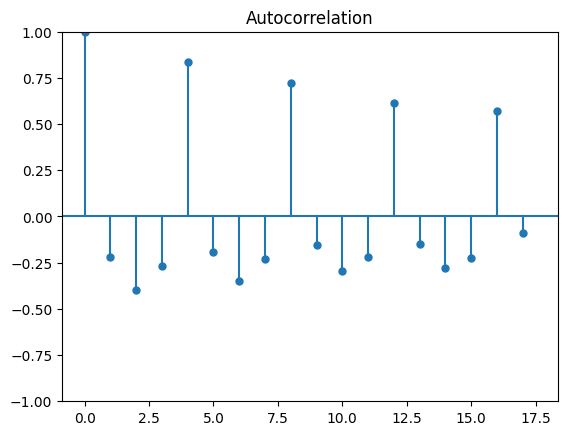

In [7]:
# Compute the acf array of HRB
acf_array = acf(hrb)
print(acf_array)

# Plot the acf function
plot_acf(hrb, alpha=1)
plt.show()

### Are We Confident This Stock is Mean Reverting?

In the last chapter, you saw that the autocorrelation of MSFT's weekly stock returns was -0.16. That autocorrelation seems large, but is it statistically significant? In other words, can you say that there is less than a 5% chance that we would observe such a large negative autocorrelation if the true autocorrelation were really zero? And are there any autocorrelations at other lags that are significantly different from zero?

Even if the true autocorrelations were zero at all lags, in a finite sample of returns you won't see the estimate of the autocorrelations exactly zero. In fact, the standard deviation of the sample autocorrelation is $1/\sqrt(N)$
where *N* is the number of observations, so if *N=100*, for example, the standard deviation of the ACF is 0.1, and since 95% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is $\pm 1.96/\sqrt{N}$. This approximation only holds when the true autocorrelations are *all* zero.

You will compute the actual and approximate confidence interval for the ACF, and compare it to the lag-one autocorrelation of -0.16 from the last chapter. The weekly returns of Microsoft is pre-loaded in a DataFrame called `returns`.

In [8]:
returns = returns.drop(returns.index[0])

The autocorrelation of weekly MSFT returns is -0.16
The approximate confidence interval is +/- 0.12


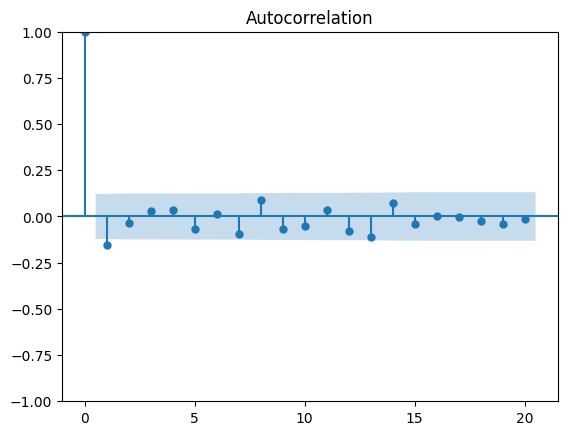

In [9]:
# Compute and print the autocorrelation of MSFT weekly returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly MSFT returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(returns)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(returns, alpha=0.05, lags=20)
plt.show()

### Can't Forecast White Noise

A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. Stock returns are often modeled as white noise. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero.

You will generate a white noise series and plot the autocorrelation function to show that it is zero for all lags. You can use `np.random.normal()` to generate random returns. For a Gaussian white noise process, the mean and standard deviation describe the entire process.

Plot this white noise series to see what it looks like, and then plot the autocorrelation function.

The mean is 0.018 and the standard deviation is 0.050


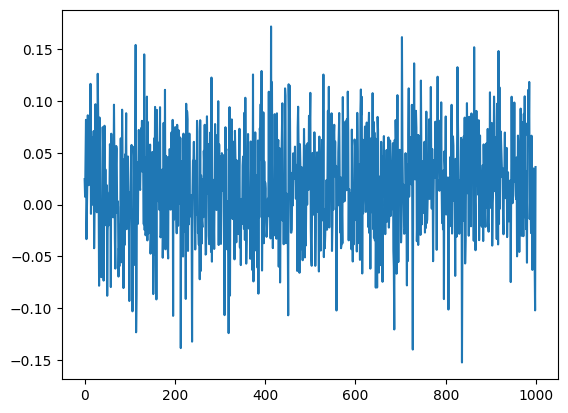

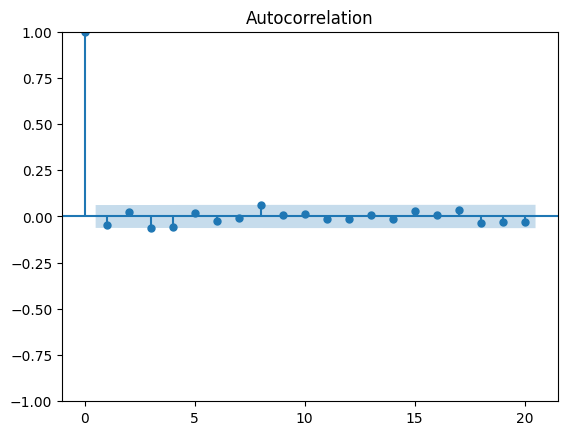

In [10]:
# Simulate white noise returns
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)

# Print out the mean and standard deviation of returns
mean = np.mean(returns)
std = np.std(returns)
print("The mean is %5.3f and the standard deviation is %5.3f" %(mean,std))

# Plot returns series
plt.plot(returns)
plt.show()

# Plot autocorrelation function of white noise returns
plot_acf(returns, lags=20)
plt.show()

### Generate a Random Walk

Whereas stock *returns* are often modeled as white noise, stock prices closely follow a random walk. In other words, today's price is yesterday's price plus some random noise.

You will simulate the price of a stock over time that has a starting price of 100 and every day goes up or down by a random amount. Then, plot the simulated stock price. If you hit the "Run Code" code button multiple times, you'll see several realizations.

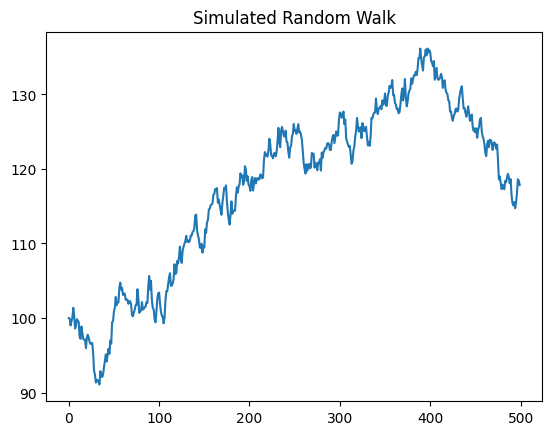

In [11]:
# Generate 500 random steps with mean=0 and standard deviation=1
steps = np.random.normal(loc=0, scale=1, size=500)

# Set first element to 0 so that the first price will be the starting stock price
steps[0]=0

# Simulate stock prices, P with a starting price of 100
P = 100 + np.cumsum(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk")
plt.show()

### Get the Drift

In the last exercise, you simulated stock prices that follow a random walk. You will extend this in two ways in this exercise.

- You will look at a random walk with a drift. Many time series, like stock prices, are random walks but tend to drift up over time.
- In the last exercise, the noise in the random walk was additive: random, normal changes in price were added to the last price. However, when adding noise, you could theoretically get negative prices. Now you will make the noise multiplicative: you will add one to the random, normal changes to get a total return, and multiply that by the last price.

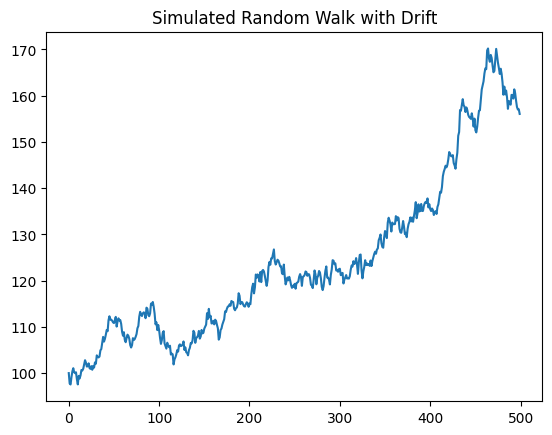

In [12]:
# Generate 500 random steps
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# Set first element to 1
steps[0]=1

# Simulate the stock price, P, by taking the cumulative product
P = 100 * np.cumprod(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk with Drift")
plt.show()

### Are Stock Prices a Random Walk?

Most stock prices follow a random walk (perhaps with a drift). You will look at a time series of Amazon stock prices, pre-loaded in the DataFrame `AMZN`, and run the 'Augmented Dickey-Fuller Test' from the statsmodels library to show that it does indeed follow a random walk.

With the ADF test, the "null hypothesis" (the hypothesis that we either reject or fail to reject) is that the series follows a random walk. Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk.

In [13]:
# Run the ADF test on the price series and print out the results
results = adfuller(amzn['Adj Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(4.025168525770743, 1.0, 33, 5054, {'1%': -3.4316445438146865, '5%': -2.862112049726916, '10%': -2.5670745025321304}, 30308.64216426981)
The p-value of the test on prices is: 1.0


### How About Stock Returns?

In the last exercise, you showed that Amazon stock prices, contained in the DataFrame `AMZN` follow a random walk. In this exercise. you will do the same thing for Amazon returns (percent change in prices) and show that the returns do not follow a random walk.

In [14]:
# Create a DataFrame of AMZN returns
AMZN_ret = amzn.pct_change()

# Eliminate the NaN in the first row of returns
AMZN_ret = AMZN_ret.dropna()

# Run the ADF test on the return series and print out the p-value
results = adfuller(AMZN_ret['Adj Close'])
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 2.5655898083466663e-22


### Seasonal Adjustment During Tax Season

Many time series exhibit strong seasonal behavior. The procedure for removing the seasonal component of a time series is called seasonal adjustment. For example, most economic data published by the government is seasonally adjusted.

You saw earlier that by taking first differences of a random walk, you get a stationary white noise process. For seasonal adjustments, instead of taking first differences, you will take differences with a lag corresponding to the periodicity.

Look again at the ACF of H&R Block's quarterly earnings, pre-loaded in the DataFrame `HRB`, and there is a clear seasonal component. The autocorrelation is high for lags 4,8,12,16,… because of the spike in earnings every four quarters during tax season. Apply a seasonal adjustment by taking the fourth difference (four represents the periodicity of the series). Then compute the autocorrelation of the transformed series.

         Earnings
Quarter          
2007Q1        NaN
2007Q2        NaN
2007Q3        NaN
2007Q4        NaN
2008Q1       0.02
2008Q2      -0.04
2008Q3      -0.05
2008Q4       0.26
2009Q1      -0.05
2009Q2       0.02


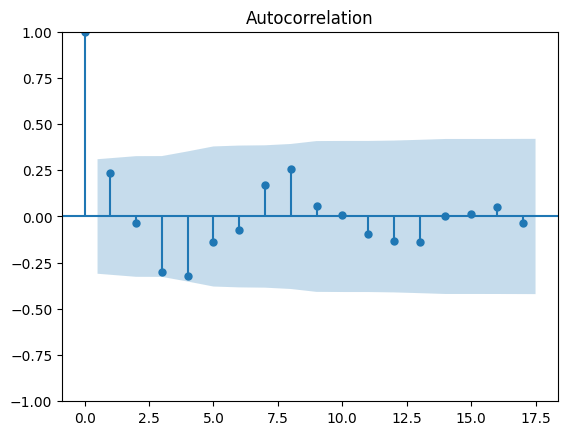

In [15]:
# Seasonally adjust quarterly earnings
HRBsa = hrb.diff(4)

# Print the first 10 rows of the seasonally adjusted series
print(HRBsa.head(10))

# Drop the NaN data in the first four rows
HRBsa = HRBsa.dropna()

# Plot the autocorrelation function of the seasonally adjusted series
plot_acf(HRBsa)
plt.show()

## Part 3 - Autoregressive (AR) Models

### Simulate AR(1) Time Series

You will simulate and plot a few AR(1) time series, each with a different parameter, $\small \phi$, using the `arima_process` module in statsmodels. In this exercise, you will look at an AR(1) model with a large positive $\small \phi$ and a large negative $\small \phi$, but feel free to play around with your own parameters.

There are a few conventions when using the `arima_process` module that require some explanation. First, these routines were made very generally to handle both AR and MA models. We will cover MA models next, so for now, just ignore the MA part. Second, when inputting the coefficients, you must include the zero-lag coefficient of 1, and the sign of the other coefficients is opposite what we have been using (to be consistent with the time series literature in signal processing). For example, for an AR(1) process with $\small \phi=0.9$, the array representing the AR parameters would be `ar = np.array([1, -0.9])`.

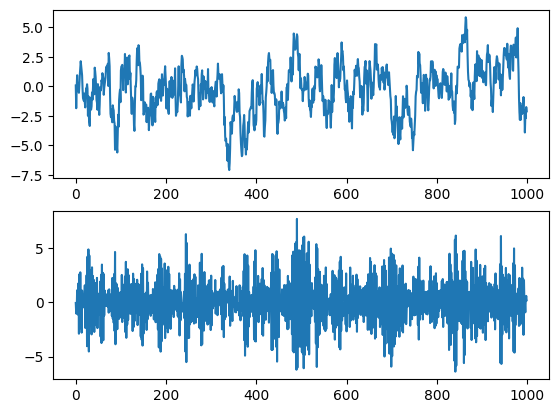

In [16]:
# Plot 1: AR parameter = +0.9
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

### Compare the ACF for Several AR Time Series

The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter. For example, if the AR parameter, $\small \phi = +0.9$, the first-lag autocorrelation will be 0.9, the second-lag will be $\small (0.9)^2 = 0.81$, the third-lag will be $\small (0.9)^3 = 0.729$, etc. A smaller AR parameter will have a steeper decay, and for a negative AR parameter, say -0.9, the decay will flip signs, so the first-lag autocorrelation will be -0.9, the second-lag will be $\small (-0.9)^2 = 0.81$, the third-lag will be $\small (-0.9)^3 = -0.729$, etc.

The object `simulated_data_1` is the simulated time series with an AR parameter of +0.9, `simulated_data_2` is for an AR parameter of -0.9, and `simulated_data_3` is for an AR parameter of 0.3.

In [17]:
ar3 = np.array([1, 0.3])
ma3 = np.array([1])
AR_object3 = ArmaProcess(ar3, ma3)
simulated_data_3 = AR_object3.generate_sample(nsample=1000)

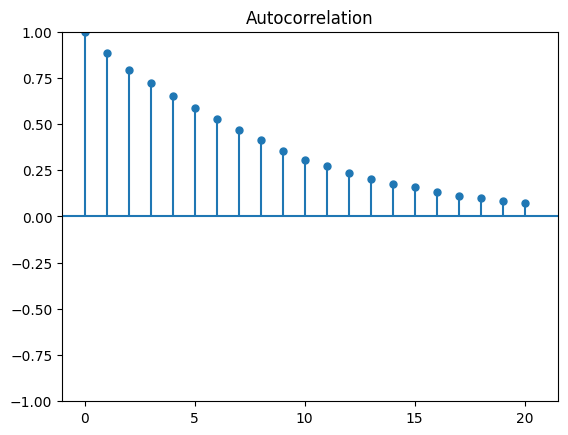

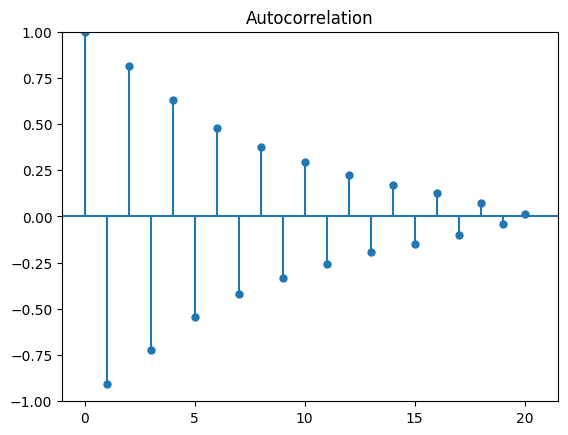

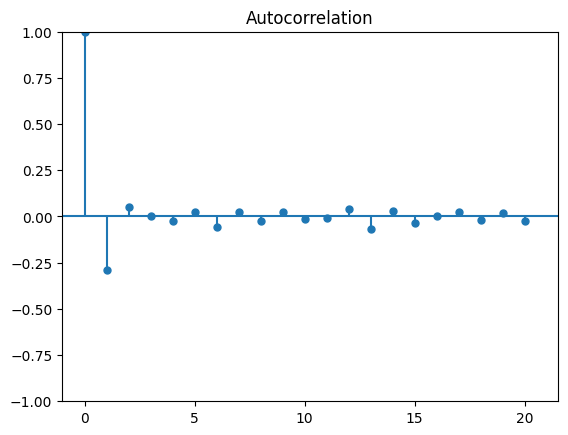

In [18]:
# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20)
plt.show()

# Plot 2: AR parameter = -0.9
plot_acf(simulated_data_2, alpha=1, lags=20)
plt.show()

# Plot 3: AR parameter = +0.3
plot_acf(simulated_data_3, alpha=1, lags=20)
plt.show()

### Estimating an AR Model

You will estimate the AR(1) parameter, $\small \phi$, of one of the simulated series that you generated in the earlier exercise. Since the parameters are known for a simulated series, it is a good way to understand the estimation routines before applying it to real data.

For `simulated_data_1` with a true $\small \phi$ of 0.9, you will print out the estimate of $\small \phi$ . In addition, you will also print out the entire output that is produced when you fit a time series, so you can get an idea of what other tests and summary statistics are available in statsmodels.

In [19]:
# Fit an AR(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(1,0,0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for phi
print("When the true phi=0.9, the estimate of phi is:")
print(res.params[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1383.118
Date:                Sat, 30 Mar 2024   AIC                           2772.236
Time:                        21:36:04   BIC                           2786.960
Sample:                             0   HQIC                          2777.832
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2949      0.259     -1.139      0.255      -0.803       0.213
ar.L1          0.8820      0.015     58.472      0.000       0.852       0.912
sigma2         0.9295      0.044     21.357      0.0

### Forecasting with an AR Model

In addition to estimating the parameters of a model that you did in the last exercise, you can also do forecasting, both in-sample and out-of-sample using statsmodels. The in-sample is a forecast of the next data point using the data up to that point, and the out-of-sample forecasts any number of data points in the future. You can plot the forecasted data using the function `plot_predict()`. You supply the starting point for forecasting and the ending point, which can be any number of data points after the data set ends.

For the simulated data in DataFrame `simulated_data_1`, with $\small \phi=0.9$, you will plot out-of-sample forecasts and confidence intervals around those forecasts.

In [20]:
data = np.random.uniform(-9, 6, size=(1000, 1))
data = np.round(data, 7)
simulated_data_1 = pd.DataFrame(data, columns=['data'])

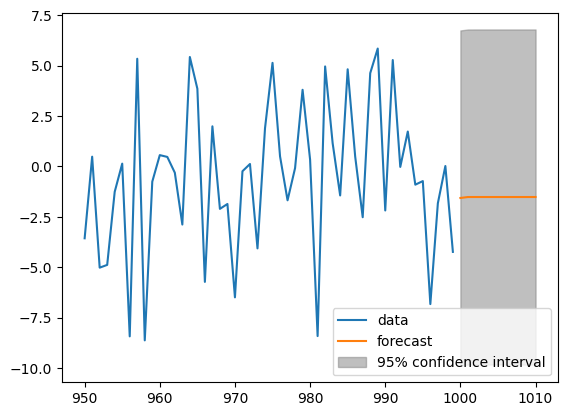

In [21]:
# Forecast the first AR(1) model
mod = ARIMA(simulated_data_1, order=(1,0,0))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
simulated_data_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

### Let's Forecast Interest Rates

You will now use the forecasting techniques you learned in the last exercise and apply it to real data rather than simulated data. You will revisit a dataset from the first chapter: the annual data of 10-year interest rates going back 56 years, which is in a Series called `interest_rate_data`. Being able to forecast interest rates is of enormous importance, not only for bond investors but also for individuals like new homeowners who must decide between fixed and floating rate mortgages.

You saw in the first chapter that there is some mean reversion in interest rates over long horizons. In other words, when interest rates are high, they tend to drop and when they are low, they tend to rise over time. Currently they are below long-term rates, so they are expected to rise, but an AR model attempts to quantify how much they are expected to rise.

The class `ARIMA` and the function `plot_predict` have already been imported.

In [22]:
data = {
    "DATE": ["1962-12-31", "1963-12-31", "1964-12-31", "1965-12-31", "1966-12-31", "1967-12-31", "1968-12-31", "1969-12-31", "1970-12-31", "1971-12-31", "1972-12-31", "1973-12-31", "1974-12-31", "1975-12-31", "1976-12-31", "1977-12-31", "1978-12-31", "1979-12-31", "1980-12-31", "1981-12-31", "1982-12-31", "1983-12-31", "1984-12-31", "1985-12-31", "1986-12-31", "1987-12-31", "1988-12-31", "1989-12-31", "1990-12-31", "1991-12-31", "1992-12-31", "1993-12-31", "1994-12-31", "1995-12-31", "1996-12-31", "1997-12-31", "1998-12-31", "1999-12-31", "2000-12-31", "2001-12-31", "2002-12-31", "2003-12-31", "2004-12-31", "2005-12-31", "2006-12-31", "2007-12-31", "2008-12-31", "2009-12-31", "2010-12-31", "2011-12-31", "2012-12-31", "2013-12-31", "2014-12-31", "2015-12-31", "2016-12-31", "2017-12-31"],
    "US10Y": [3.85, 4.14, 4.21, 4.65, 4.64, 5.70, 6.16, 7.88, 6.50, 5.89, 6.41, 6.90, 7.40, 7.76, 6.81, 7.78, 9.15, 10.33, 12.43, 13.98, 10.36, 11.82, 11.55, 9.00, 7.23, 8.83, 9.14, 7.93, 8.08, 6.71, 6.70, 5.83, 7.84, 5.58, 6.43, 5.75, 4.65, 6.45, 5.12, 5.07, 3.83, 4.27, 4.24, 4.39, 4.71, 4.04, 2.25, 3.85, 3.30, 1.89, 1.78, 3.04, 2.17, 2.27, 2.45, 2.16]
}
interest_rate_data = pd.DataFrame(data)
interest_rate_data['DATE'] = pd.to_datetime(interest_rate_data['DATE'])
interest_rate_data.set_index('DATE', inplace=True)

/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YE-DEC will be used.
  self._init_dates(dates, freq)


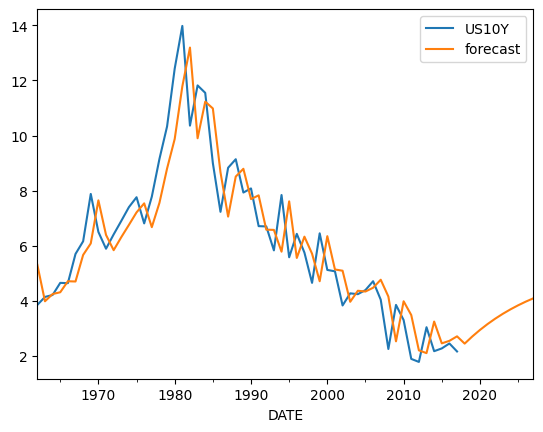

In [23]:
# Forecast interst rates using an AR(1) model
mod = ARIMA(interest_rate_data, order=(1,0,0))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
interest_rate_data.plot(ax=ax)
plot_predict(res, start=0, end='2027', alpha=None, ax=ax)
plt.show()

### Compare AR Model with Random Walk

Sometimes it is difficult to distinguish between a time series that is slightly mean reverting and a time series that does not mean revert at all, like a random walk. You will compare the ACF for the slightly mean-reverting interest rate series of the last exercise with a simulated random walk with the same number of observations.

You should notice when plotting the autocorrelation of these two series side-by-side that they look very similar.

In [24]:
simulated_data = np.array([
    5.        , 4.77522278, 5.60354317, 5.96406402, 5.97965372,
    6.02771876, 5.5470751 , 5.19867084, 5.01867859, 5.50452928,
    5.89293842, 4.6220103 , 5.06137835, 5.33377592, 5.09333293,
    5.37389022, 4.9657092 , 5.57339283, 5.48431854, 4.68588587,
    5.25218625, 4.34800798, 4.34544412, 4.72362568, 4.12582912,
    3.54622069, 3.43999885, 3.77116252, 3.81727011, 4.35256176,
    4.13664247, 3.8745768 , 4.01630403, 3.71276593, 3.55672457,
    3.07062647, 3.45264414, 3.28123729, 3.39193866, 3.02947806,
    3.88707349, 4.28776889, 3.47360734, 3.33260631, 3.09729579,
    2.94652178, 3.50079273, 3.61020341, 4.23021143, 3.94289347,
    3.58422345, 3.18253962, 3.26132564, 3.19777388, 3.43527681,
    3.37204482
])

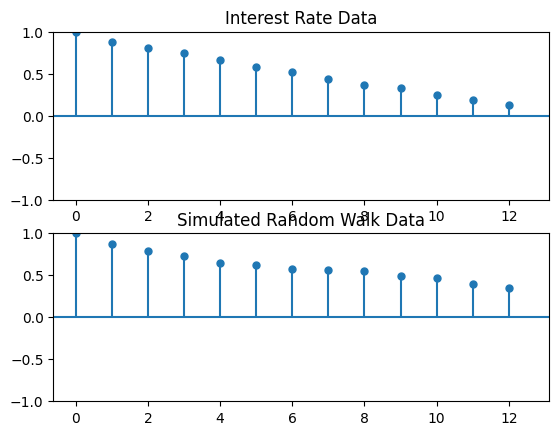

In [25]:
# Plot the interest rate series and the simulated random walk series side-by-side
fig, axes = plt.subplots(2,1)

# Plot the autocorrelation of the interest rate series in the top plot
fig = plot_acf(interest_rate_data, alpha=1, lags=12, ax=axes[0])

# Plot the autocorrelation of the simulated random walk series in the bottom plot
fig = plot_acf(simulated_data, alpha=1, lags=12, ax=axes[1])

# Label axes
axes[0].set_title("Interest Rate Data")
axes[1].set_title("Simulated Random Walk Data")
plt.show()

### Estimate Order of Model: PACF

One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF). In this exercise, you will simulate two time series, an AR(1) and an AR(2), and calculate the sample PACF for each. You will notice that for an AR(1), the PACF should have a significant lag-1 value, and roughly zeros after that. And for an AR(2), the sample PACF should have significant lag-1 and lag-2 values, and zeros after that.

Just like you used the `plot_acf` function in earlier exercises, here you will use a function called `plot_pacf` in the statsmodels module.

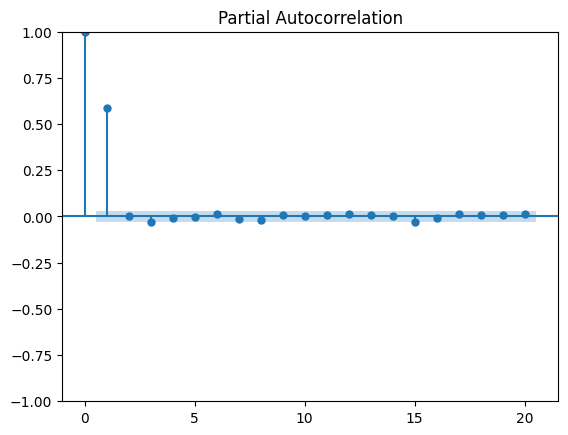

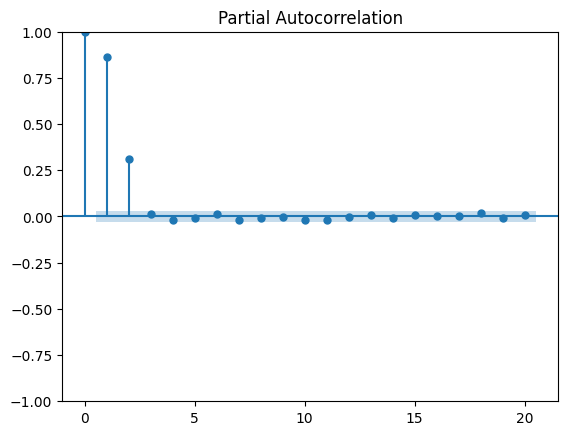

In [26]:
# Simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20)
plt.show()

# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(2)
plot_pacf(simulated_data_2, lags=20)
plt.show()

### Estimate Order of Model: Information Criteria

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. You will take the AR(2) simulated data from the last exercise, saved as `simulated_data_2`, and compute the BIC as you vary the order, p, in an AR(p) from 0 to 6.

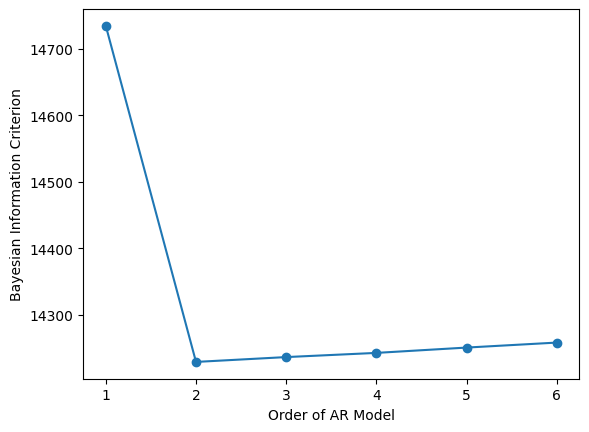

In [27]:
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(simulated_data_2, order=(p, 0, 0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

## Part 4 - Moving Average (MA) and ARMA Models

### Simulate MA(1) Time Series

You will simulate and plot a few MA(1) time series, each with a different parameter, $\small \theta$, using the `arima_process` module in statsmodels, just as you did in the last chapter for AR(1) models. You will look at an MA(1) model with a large positive $\small \theta$ and a large negative $\small \theta$.

As in the last chapter, when inputting the coefficients, you must include the zero-lag coefficient of 1, but unlike the last chapter on AR models, the sign of the MA coefficients is what we would expect. For example, for an MA(1) process with $\small \theta=-0.9$, the array representing the MA parameters would be `ma = np.array([1, -0.9])`.

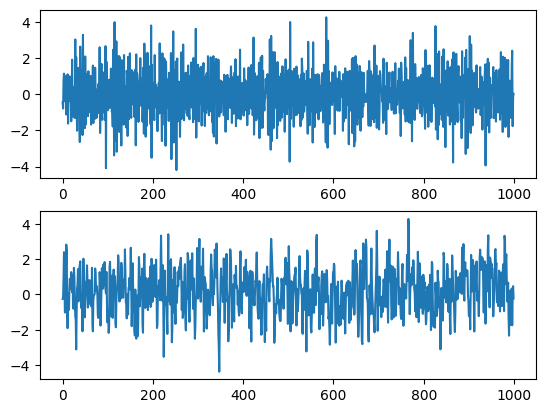

In [28]:
# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
plt.subplot(2,1,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

plt.show()

### Compute the ACF for Several MA Time Series

Unlike an AR(1), an MA(1) model has no autocorrelation beyond lag 1, an MA(2) model has no autocorrelation beyond lag 2, etc. The lag-1 autocorrelation for an MA(1) model is not $\small \theta$, but rather $\small \theta / (1+\theta^2)$. For example, if the MA parameter, $\small \theta$, is = +0.9, the first-lag autocorrelation will be $\small 0.9/(1+(0.9)^2)=0.497$, and the autocorrelation at all other lags will be zero. If the MA parameter, $\small \theta$, is -0.9, the first-lag autocorrelation will be $\small -0.9/(1+(-0.9)^2)=-0.497$.

You will verify these autocorrelation functions for the three time series you generated in the last exercise.

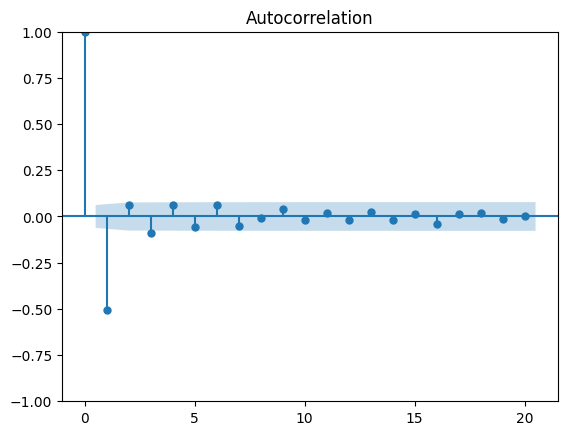

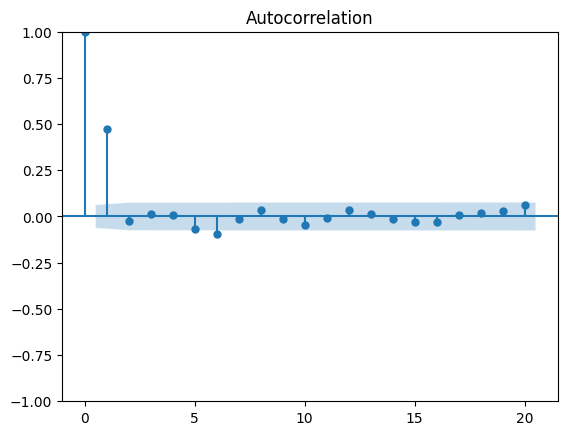

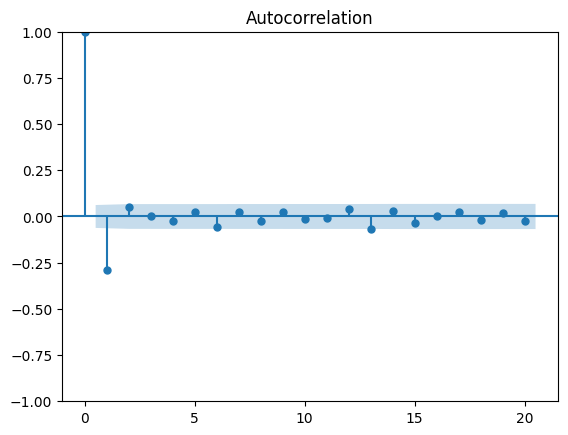

In [29]:
# Plot 1: MA parameter = -0.9
plot_acf(simulated_data_1, lags=20)
plt.show()

# Plot 2: MA parameter = 0.9
plot_acf(simulated_data_2, lags=20)
plt.show()

# Plot 3: MA parameter = -0.3
plot_acf(simulated_data_3, lags=20)
plt.show()

### Estimating an MA Model

You will estimate the MA(1) parameter, $\small \theta$, of one of the simulated series that you generated in the earlier exercise. Since the parameters are known for a simulated series, it is a good way to understand the estimation routines before applying it to real data.

For `simulated_data_1` with a true $\small \theta$ of -0.9, you will print out the estimate of $\small \theta$. In addition, you will also print out the entire output that is produced when you fit a time series, so you can get an idea of what other tests and summary statistics are available in statsmodels.

In [30]:
# Fit an MA(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta is:")
print(res.params[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1421.858
Date:                Sat, 30 Mar 2024   AIC                           2849.716
Time:                        21:37:00   BIC                           2864.439
Sample:                             0   HQIC                          2855.312
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.003      0.262      0.794      -0.005       0.006
ma.L1         -0.9152      0.013    -70.078      0.000      -0.941      -0.890
sigma2         1.0040      0.047     21.333      0.0

### Forecasting with MA Model

As you did with AR models, you will use MA models to forecast in-sample and out-of-sample data using the `plot_predict()` function in statsmodels.

For the simulated series `simulated_data_1` with $\small \theta=-0.9$, you will plot in-sample and out-of-sample forecasts. One big difference you will see between out-of-sample forecasts with an MA(1) model and an AR(1) model is that the MA(1) forecasts more than one period in the future are simply the mean of the sample.

In [31]:
data = np.random.uniform(-5, 4, size=(1000, 1))
data = np.round(data, 7)
simulated_data_1 = pd.DataFrame(data, columns=['data'])

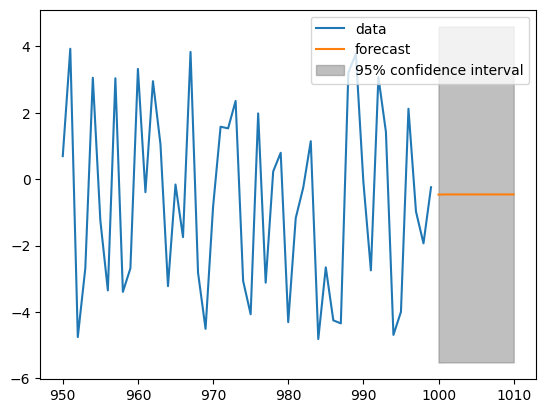

In [32]:
# Forecast the first MA(1) model
mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
simulated_data_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

### High Frequency Stock Prices

Higher frequency stock data is well modeled by an MA(1) process, so it's a nice application of the models in this chapter.

The DataFrame `intraday` contains one day's prices (on September 1, 2017) for Sprint stock (ticker symbol "S") sampled at a frequency of one minute. The stock market is open for 6.5 hours (390 minutes), from 9:30am to 4:00pm.

Before you can analyze the time series data, you will have to clean it up a little, which you will do in this and the next two exercises. When you look at the first few rows (see the IPython Shell), you'll notice several things. First, there are no column headers.The data is not time stamped from 9:30 to 4:00, but rather goes from 0 to 390. And you will notice that the first date is the odd-looking "a1504272600". The number after the "a" is Unix time which is the number of seconds since January 1, 1970. This is how this dataset separates each day of intraday data.

If you look at the data types, you'll notice that the `DATE` column is an object, which here means a string. You will need to change that to numeric before you can clean up some missing data.

The source of the minute data is Google Finance (see [here](https://www.quantshare.com/sa-426-6-ways-to-download-free-intraday-and-tick-data-for-the-us-stock-market) on how the data was downloaded).

In [33]:
intraday = sprint_intraday.iloc[:, :2]

In [34]:
# Change the first date to zero
intraday.iloc[0,0] = 0

# Change the column headers to 'DATE' and 'CLOSE'
intraday.columns = ['DATE', 'CLOSE']

# Examine the data types for each column
print(intraday.dtypes)

# Convert DATE column to numeric
intraday['DATE'] = pd.to_numeric(intraday['DATE'])

# Make the `DATE` column the new index
intraday = intraday.set_index('DATE')

DATE       int64
CLOSE    float64
dtype: object


### More Data Cleaning: Missing Data

When you print out the length of the DataFrame `intraday`, you will notice that a few rows are missing. There will be missing data if there are no trades in a particular one-minute interval. One way to see which rows are missing is to take the difference of two sets: the full set of every minute and the set of the DataFrame index which contains missing rows. After filling in the missing rows, you can convert the index to time of day and then plot the data.

Stocks trade at discrete one-cent increments (although a small percentage of trades occur in between the one-cent increments) rather than at continuous prices, and when you plot the data you should observe that there are long periods when the stock bounces back and forth over a one cent range. This is sometimes referred to as "bid/ask bounce".

In [35]:
# Notice that some rows are missing
print("If there were no missing rows, there would be 391 rows of minute data")
print("The actual length of the DataFrame is:", len(intraday))

# Everything
set_everything = set(range(391))

# The intraday index as a set
set_intraday = set(intraday.index)

# Calculate the difference
set_missing = set_everything - set_intraday

# Print the difference
print("Missing rows: ", set_missing)

If there were no missing rows, there would be 391 rows of minute data
The actual length of the DataFrame is: 388
Missing rows:  {1, 182, 14}


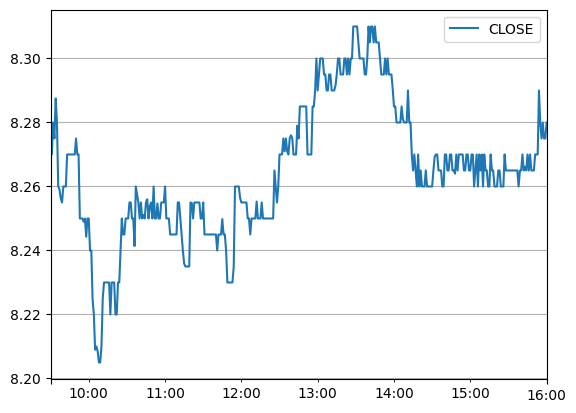

In [36]:
# Fill in the missing rows
intraday = intraday.reindex(range(391), method='ffill')

# Change the index to the intraday times
intraday.index = pd.date_range(start='2017-09-01 9:30', end='2017-09-01 16:00', freq='1min')

# Plot the intraday time series
intraday.plot(grid=True)
plt.show()

### Applying an MA Model

The bouncing of the stock price between bid and ask induces a negative first order autocorrelation, but no autocorrelations at lags higher than 1. You get the same ACF pattern with an MA(1) model. Therefore, you will fit an MA(1) model to the intraday stock data from the last exercise.

The first step is to compute minute-by-minute returns from the prices in `intraday`, and plot the autocorrelation function. You should observe that the ACF looks like that for an MA(1) process. Then, fit the data to an MA(1), the same way you did for simulated data.

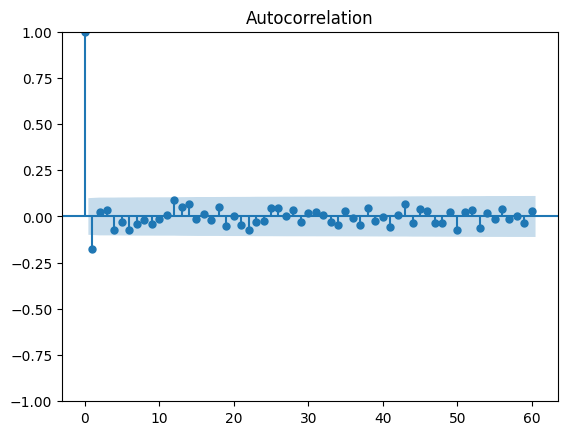

-0.17148026244716333


/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/5w/p7yy3fld65s2kfyhmv6zr0_00000gn/T/ipykernel_5279/1329003255.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(res.params[1])


In [37]:
# Compute returns from prices and drop the NaN
returns = intraday.pct_change()
returns = returns.dropna()

# Plot ACF of returns with lags up to 60 minutes
plot_acf(returns, lags=60)
plt.show()

# Fit the data to an MA(1) model
mod = ARIMA(returns, order=(0,0,1))
res = mod.fit()
print(res.params[1])

### Equivalence of AR(1) and MA(infinity)

To better understand the relationship between MA models and AR models, you will demonstrate that an AR(1) model is equivalent to an MA($\small \infty$) model with the appropriate parameters.

You will simulate an MA model with parameters $\small 0.8, 0.8^2, 0.8^3, \ldots$ for a large number (30) lags and show that it has the same Autocorrelation Function as an AR(1) model with $\small \phi=0.8$.

*Note, to raise a number `x` to the power of an exponent `n`, use the format `x**n`.*

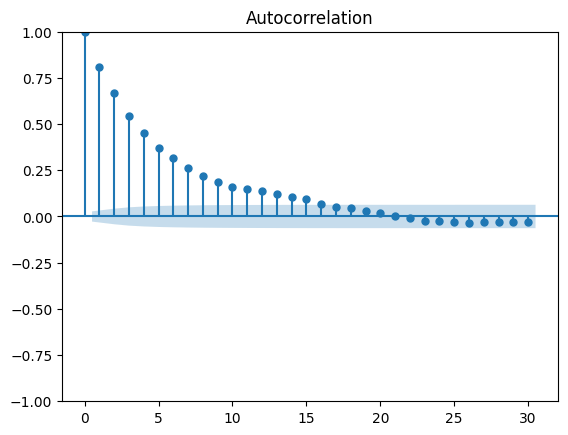

In [38]:
# Build a list MA parameters
ma = [0.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.show()

## Part 5 - Putting It All Together

### A Dog on a Leash? (Part 1)

The Heating Oil and Natural Gas prices are pre-loaded in DataFrames `HO` and `NG`. First, plot both price series, which look like random walks. Then plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we multiply the heating oil prices, in \$/gallon, by 7.25, which converts it to \$/millionBTU, which is the same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a continuous series as contracts expire) was obtained from [Quandl](https://blog.quandl.com/api-for-futures-data).

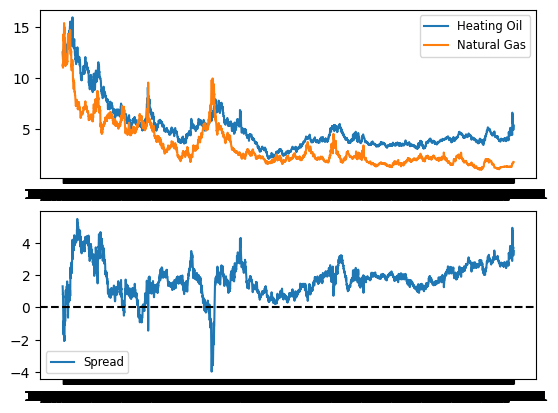

In [39]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*ho, label='Heating Oil')
plt.plot(ng, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*ho-ng, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

### A Dog on a Leash? (Part 2)

To verify that Heating Oil and Natural Gas prices are cointegrated, First apply the Dickey-Fuller test separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. The Heating Oil and Natural Gas prices are pre-loaded in DataFrames `HO` and `NG`.

In [40]:
# Compute the ADF for HO and NG
result_HO = adfuller(ho)
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(ng['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * ho - ng)
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.019831028071625706
The p-value for the ADF test on NG is  0.0045472849565425365
The p-value for the ADF test on the spread is  0.00011887051827353336


### Are Bitcoin and Ethereum Cointegrated?

Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was $\small (1,-1)$. In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient $\small b$, then the cointegration vector is simply $\small (1,-b)$. Then perform the ADF test on BTC $\small - b$ ETH. Bitcoin and Ethereum prices are pre-loaded in DataFrames `BTC` and `ETH`.

In [ ]:
# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b*ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])

### Is Temperature a Random Walk (with Drift)?

An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

The DataFrame `temp_NY` contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA [here](https://www.ncdc.noaa.gov/cdo-web/search)). Plot the data and test whether it follows a random walk (with drift).

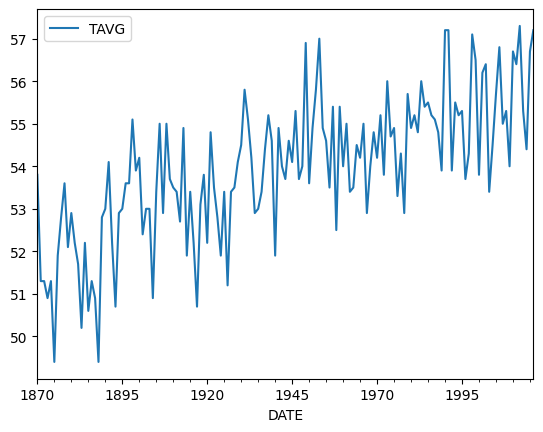

The p-value for the ADF test is  0.5832938987871135


In [41]:
# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

### Getting "Warmed" Up: Look at Autocorrelations

Since the temperature series, `temp_NY`, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

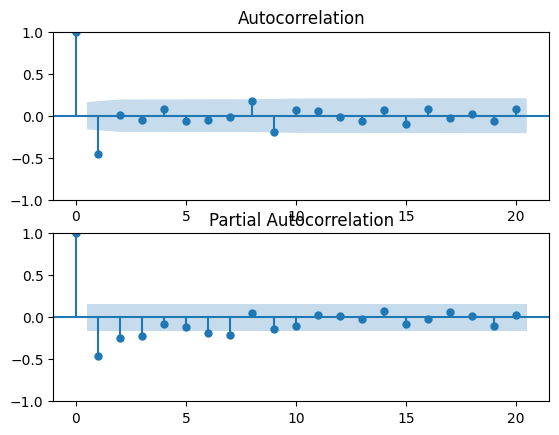

In [42]:
# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

### Which ARMA Model is Best?

Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

The annual change in temperature is in a DataFrame `chg_temp`.

In [43]:
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2, 0, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1, 1, 0))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

The AIC for an AR(1) is:  510.5346898733108
The AIC for an AR(2) is:  501.92741234091363
The AIC for an ARMA(1,1) is:  611.5665057979247


/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473

### Don't Throw Out That Winter Coat Yet

Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

Because temperatures are trending up over time, you will also need to add a trend component when you define the ARIMA model. In the exercise, you'll use a linear trend with time by setting the argument `trend='t'`. You can also try other trend models to see how the forecasts change. For example, for a quadratic trend $\small  a+ bt + ct^2$, set `trend=[0,1,1]`, to include both a linear term, $\small bt$, and quadratic term, $\small ct^2$, in the model.

The data is preloaded in a DataFrame called `temp_NY`.

/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/gabriel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


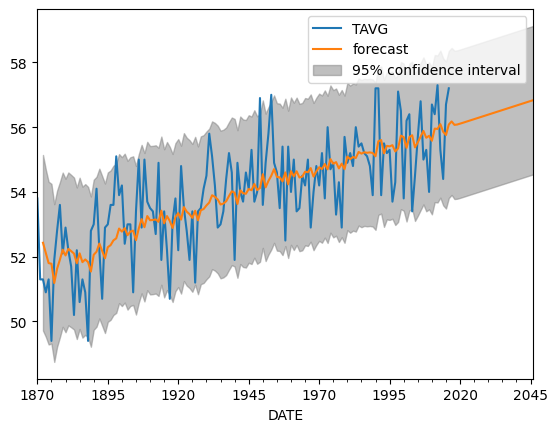

In [44]:
# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()